In [1]:
%config Completer.use_jedi = False

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp , routing_parameters_pb2
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from Route_Optimizer import RouteOptimizer
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668

dataset = "../datasets/UK10_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
#station_coordinates = generate_coordinates(station_data)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [3]:
# Temporary printer function. Should be remade to be more diverse but works for now
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    vehicle_solutions = {}
    route_data = {"Distances":[],"Loads":[]}
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        vehicle_solutions[vehicle_id] = []
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            if index > distance_data.shape[0]-1:
                vehicle_solutions[vehicle_id].append(0)
            else:
                vehicle_solutions[vehicle_id].append(index)
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            
            previos_id = previous_index if previous_index <= 10 else 0
            idx = index if index <= 10 else 0
            route_distance += data['distance_matrix'][previos_id][idx]
            route_load += data['demands'][idx]
            

        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}kg\n'.format(route_load)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        route_data["Distances"].append(route_distance)
        route_data["Loads"].append(route_load)
    print('Maximum of the route distances: {}m'.format(max_route_distance))
    print('Sum of the route distances: {}m'.format(sum(route_data["Distances"])))

## Construct data model parameters

In [4]:

distance_matrix = make_open_problem(squareform(pdist(points_coordinate)))

vehicle_amount = 2

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy().tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]

depot = 0

data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
                   'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'depot':depot}


## Create data model

In [5]:

data = create_data_model_depot(**data_model_input)


## Construct Simulated Annealing class

In [6]:
class Optimizer_SA(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.time_limit.seconds = 1
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_INSERTION)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
        return search_parameters

## Set up constraints

In [7]:

def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]


## Add constraints and weights. This should be turned in to functions in the future

In [8]:
# Create the routing index manager.
manager = create_routing_index_manager(data)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# ========== Add capacity cost & constraint to routing model ==========
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
dimension_name = 'Capacity'
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(1)

# =====================================================================


# ========== Add distance cost & constraint to routing model ==========
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    2500000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
# Set distance weight to a high number since using coordinates
distance_dimension.SetGlobalSpanCostCoefficient(10000)
# =====================================================================

# Create callback object for storing cost values
callback = Callback(routing)


## Create optimizer and set parameters

In [9]:
optimizerSA = Optimizer_SA(data)

optimizerSA.set_manager(manager)
optimizerSA.set_routing(routing)
optimizerSA.set_solution_callback(callback)

## Solve problem

In [10]:
optimizerSA.solve_with_parameters()

## Plot learning curve

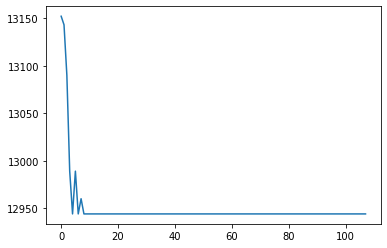

In [11]:
plt.plot(optimizerSA.solutionCallback.costs)

## Plot generated routes on map

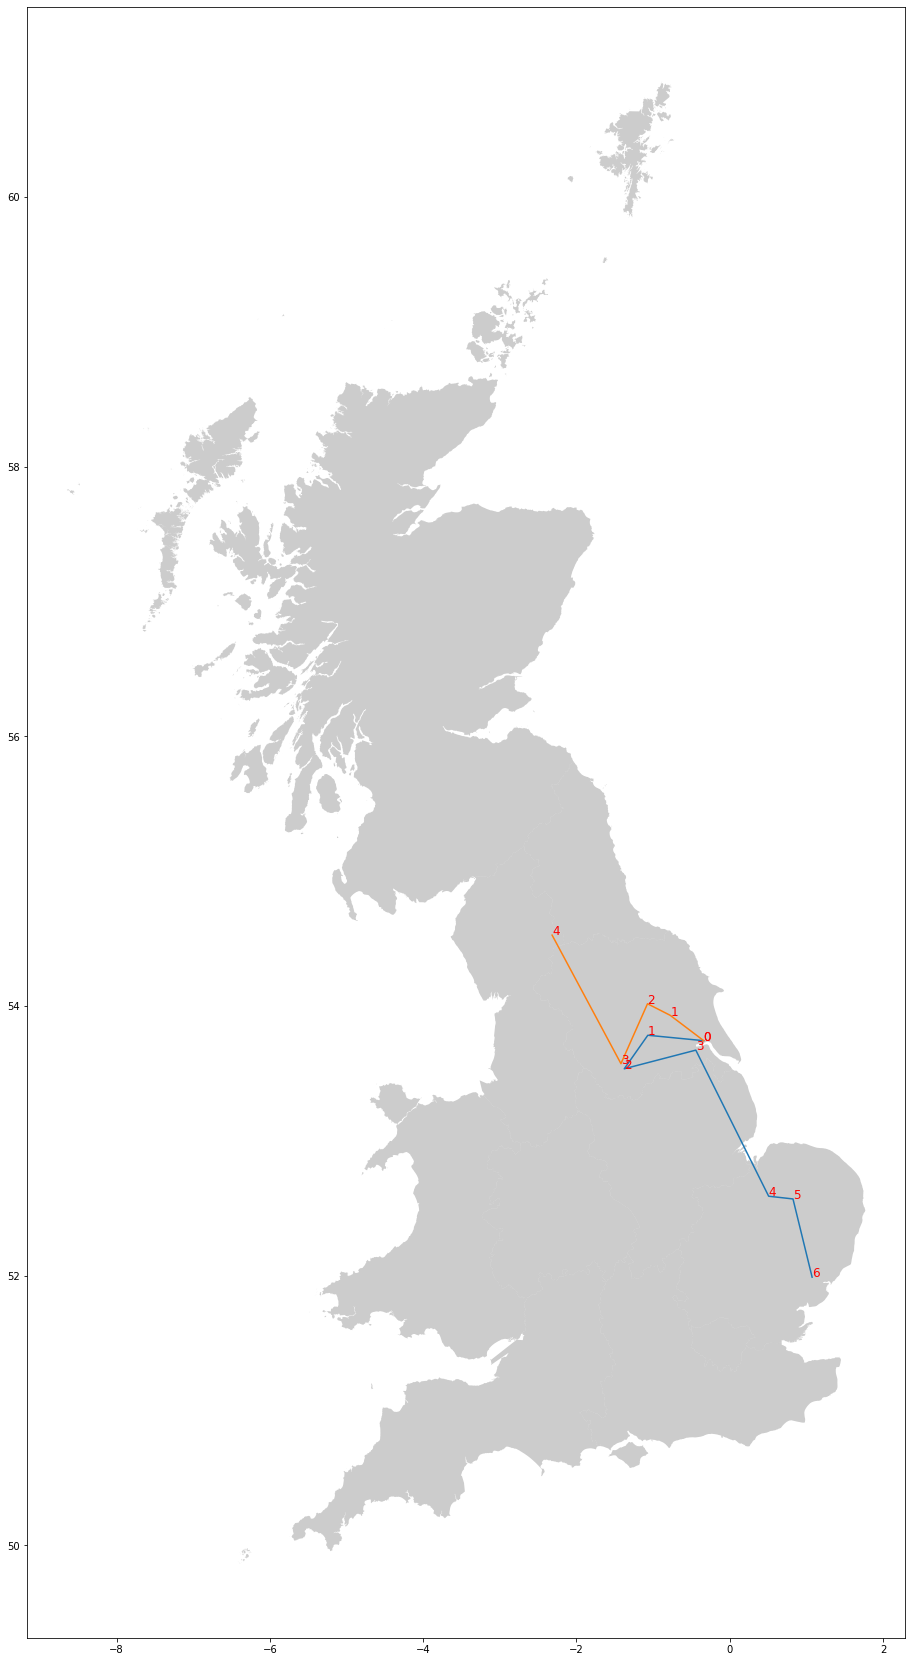

In [12]:
plot_routes(optimizerSA.get_routes(),points_coordinate,dbf,station_ids = False)